# Часть первая, с блекджеком и стратегиями #
Мы будем обучаться играть в очень простую, но знаменитую и популярную игру: блекджек.

Простейший вариант блекджека реализован в OpenAI Gym: 
https://github.com/openai/gym/blob/master/gym/envs/toy_text/blackjack.py 

1. Рассмотрим очень простую стратегию: говорить stand, если у нас на руках комбинация в 19, 20 или 21 очко, во всех остальных случаях говорить hit. Используйте методы Монте-Карло, чтобы оценить выигрыш от этой стратегии.

Использованы материалы из https://github.com/PabloRR100/Reinforcement-Learning/tree/master/1_Classic_RL/

In [1]:
import sys
import gym
import numpy as np
from matplotlib import pyplot
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from collections import defaultdict
import random
from functools import partial
%matplotlib inline
plt.style.use('ggplot')
from IPython.display import clear_output
import matplotlib

In [2]:
env = gym.make('Blackjack-v1')

def sample_policy(state):
    score, dealer_score, usable_ace = state
    return 0 if score >= 19 else 1

In [3]:
def generate_episode_fixed_policy(env):
    episode = []
    state = env.reset()
    while True:
        action = sample_policy(state)
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        state = next_state
        if done:
            break
    return episode    

In [4]:
def mc_prediction_q(env, num_episodes, generate_episode, gamma=1.0):    
    returns_sum = defaultdict(lambda: np.zeros(env.action_space.n))
    N = defaultdict(lambda: np.zeros(env.action_space.n))
    Q = defaultdict(lambda: np.zeros(env.action_space.n))
    for i_episode in range(1, num_episodes+1):        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()
        episode = generate_episode(env)
        states, actions, rewards = zip(*episode)
        discounts = np.array([gamma**i for i in range(len(rewards)+1)])

        for i, state in enumerate(states):
            returns_sum[state][actions[i]] += sum(rewards[i:]*discounts[:-(1+i)])
            N[state][actions[i]] += 1.0 
            Q[state][actions[i]] = returns_sum[state][actions[i]] / N[state][actions[i]]        
    return Q

In [5]:
def plot_blackjack_values(V):

    def get_Z(x, y, usable_ace):
        if (x,y,usable_ace) in V:
            return V[x,y,usable_ace]
        else:
            return 0

    def get_figure(usable_ace, ax):
        x_range = np.arange(11, 22)
        y_range = np.arange(1, 11)
        X, Y = np.meshgrid(x_range, y_range)
        
        Z = np.array([get_Z(x,y,usable_ace) for x,y in zip(np.ravel(X), np.ravel(Y))]).reshape(X.shape)

        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=plt.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player\'s Current Sum')
        ax.set_ylabel('Dealer\'s Showing Card')
        ax.set_zlabel('State Value')
        ax.view_init(ax.elev, -120)

    fig = plt.figure(figsize=(20, 20))
    ax = fig.add_subplot(211, projection='3d')
    ax.set_title('Usable Ace')
    get_figure(True, ax)
    ax = fig.add_subplot(212, projection='3d')
    ax.set_title('No Usable Ace')
    get_figure(False, ax)
    plt.show()

Episode 1000000/1000000.

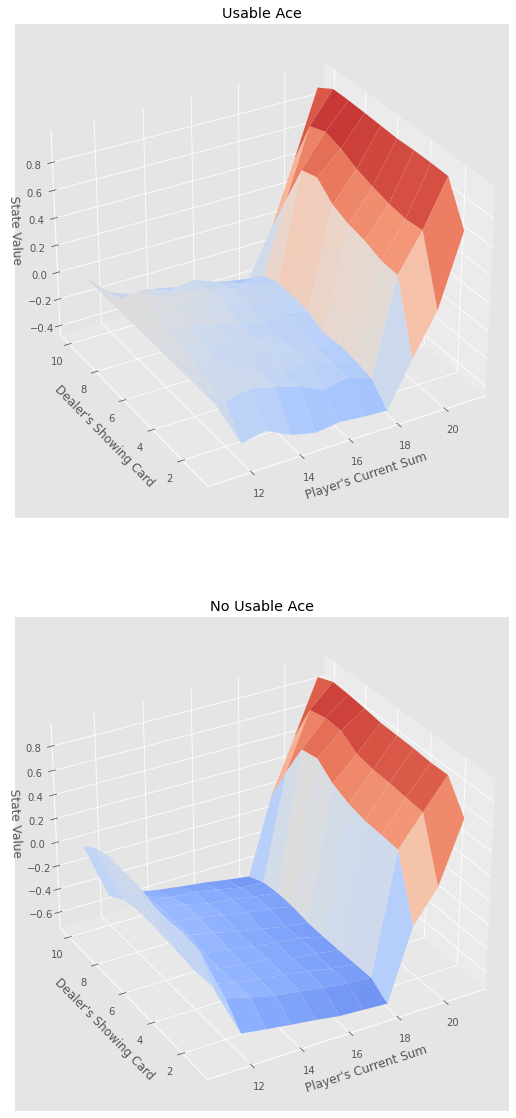

In [6]:
Q = mc_prediction_q(env, 1000000, generate_episode_fixed_policy)

V_to_plot = dict((k,(k[0]>18)*(np.dot([1, 0],v)) + (k[0]<=18)*(np.dot([0, 1],v))) \
         for k, v in Q.items())
plot_blackjack_values(V_to_plot)

2. Реализуйте метод обучения с подкреплением без модели (можно Q-обучение, но рекомендую попробовать и другие, например Monte Carlo control) для обучения стратегии в блекджеке, используя окружение Blackjack-v0 из OpenAI Gym.

In [7]:
def mc_control(env, num_episodes, alpha, gamma=0.9, eps0=1.0, eps_decay=.99999, eps_min=0.05):
    
    # Variable to store all the possible actions of the environment
    nA = env.action_space.n
    
    # Initialize empty dictionary of arrays
    Q = defaultdict(lambda: np.zeros(nA))
    
    # Initialize epsilon
    eps = eps0
    rewards = []
    
    # Loop over episodes
    for i_episode in range(1, num_episodes+1):
        
        if i_episode % 1000 == 0:
            print("\rEpisode {}/{}.".format(i_episode, num_episodes), end="")
            sys.stdout.flush()

        # Recalculate epsilon with a scheduler (a simple decay)
        eps = max(eps*eps_decay, eps_min)
        
        # Run the episode by following the eps-greedy policy
        episode, reward = generate_episode_from_Q(env, Q, eps, nA)
        rewards.append(reward)
        # Update the Q-Table values
        Q = update_Q(env, episode, Q, alpha, gamma)
    
    # Unroll our Q-Table picking the best action at each state (row) to define the found optimal policy
    policy = dict((k,np.argmax(v)) for k, v in Q.items())
        
    return policy, Q, rewards

In [8]:
def generate_episode_from_Q(env, Q, eps, nA):
    '''
    Function to generate a MC episode given the environment, the last Q-Table,
    the ratio of exploration and the total number of actions
    Returns: and episode as a 3-tuple of (states, actions, rewards)
    '''
    # Initialize an empty env to run the new episode
    episode = []
    state = env.reset()
    
    # Until terminal state
    while True:
        
        # Generate an action following the policy
        action = np.random.choice(np.arange(nA), p=get_probs(Q[state], eps, nA)) if state in Q else env.action_space.sample()
        
        # Perform the 3-tuple for that state - Every visit approach
        next_state, reward, done, info = env.step(action)
        episode.append((state, action, reward))
        
        # Advance one state 
        state = next_state
        if done:
            break
    
    return episode, reward

In [9]:
def get_probs(Qs, eps, nA):
    '''
    Function that obtains the probabilites corresponding to e-greedy policy
    '''
    # 1 - Initial equal radom probability for every possible action
    policy_s = np.ones(nA) * eps / nA
    
    # 2 - Determine which is the current optimal action for that state
    best_a = np.argmax(Qs)
    
    # 3 - Update (increase) the probability for the optimal action
    policy_s[best_a] = 1 - eps + (eps / nA)
    
    return policy_s

In [10]:
def update_Q(env, episode, Q, alpha, gamma):
    '''
    Function to update the Q-Table after running 1 episode
    '''
    # 1 - Extract the information of the run episode
    states, actions, rewards = zip(*episode)
    
    # 2 - Apply the discount factor
    discounts = np.array([gamma**i for i in range(len(rewards)+1)])
    
    # 3 - Apply the update function to every Q(s,a) <- Q(s,a) + alpha*[Gt - Q(s,a)]
    for i, s in enumerate(states):        
        a = actions[i]
        old_Q = Q[s][a]
        Q[s][a] = old_Q + alpha*(sum(rewards[i:]*discounts[:-(1+i)]) - old_Q)
    return Q

In [11]:
# The value for alpha and the number of episodes have been set after trial and error
policy, Q, rewards = mc_control(env, 1000000, 0.1)

Episode 1000000/1000000.

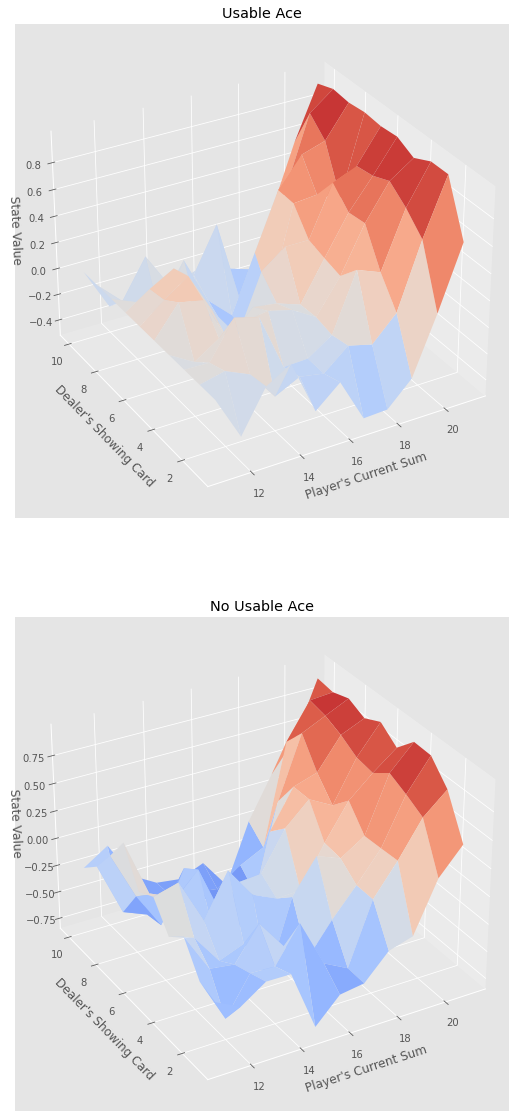

In [12]:
# obtain the corresponding state-value function
V = dict((k,np.max(v)) for k, v in Q.items())

# plot the state-value function
plot_blackjack_values(V)

3. Сколько выигрывает казино у вашей стратегии? Нарисуйте графики среднего дохода вашего метода (усреднённого по крайней мере по 100000 раздач, а лучше больше) по ходу обучения. Попробуйте подобрать оптимальные гиперпараметры.


In [13]:
avg_rewards = []
sum_ = 0
for i in range(len(rewards)):
    sum_ += rewards[i]
    if i % 100000 == 0:
        sum_ /= 100000
        avg_rewards.append(sum_)
        sum_ = 0  
        
def show_rewards(avg_rewards):
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.grid(None)
    ax.scatter(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('MC control rewards')

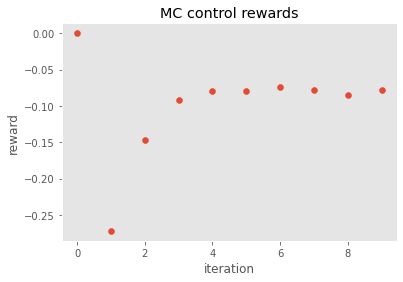

In [14]:
show_rewards(avg_rewards)

alpha: Step-size parameter for the update step - наилучший 0.1

gamma: Discount rate for the rewards - наилучший 0.9

# Часть вторая, удвоенная #
В базовый блекджек, описанный в предыдущем разделе, обыграть казино вряд ли получится. Но, к счастью, на этом история не заканчивается. Описанные выше правила были упрощёнными, а на самом деле у игрока есть ещё и другие возможности. Реализовывать split может оказаться непросто, поэтому давайте ограничимся удвоением ставки. Итак, у игрока появляется дополнительное действие:
- double — удвоить ставку; при этом больше действий делать нельзя, игроку выдаётся ровно одна дополнительная карта, а выигрыш или проигрыш удваивается.

4. Реализуйте новый вариант блекджека на основе окружения Blackjack-v0 из OpenAI Gym, в котором разрешено удвоение ставки.
5. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Использованы материалы из https://www.kaggle.com/angps95/blackjack-strategy-using-reinforcement-learning

In [15]:
import Blackjack_double

In [16]:
env = Blackjack_double.BlackjackEnv()
_ = env.reset()

In [17]:
rewards = []

def get_action(env, Q, state, epsilon):
    if state not in Q:
        Q[state] = np.zeros(env.action_space.n)

    random_action_prob = random.choices([0, 1], [epsilon, 1 - epsilon])

    if (random_action_prob):
        action = int(np.argmax(Q[state]))
    else:
        action = np.random.randint(0, env.action_space.n)   
    return action

def off_pol_TD_Q_learn(env, episodes, epsilon, alpha, gamma, eps_decay=.99999, eps_min=0.05):
    """
    Off-Policy TD Q-Learning Method
    
    Args:
        env: OpenAI gym environment.
        episodes: Number of episodes to sample.
        epsilon: Probability of selecting random action instead of the 'optimal' action
        alpha: Learning Rate
        gamma: Gamma discount factor
        
    
    Returns:
        A tuple (Q, policy).
        Q is a dictionary mapping state -> action values.
        policy is a function that takes an observation as an argument and returns
        action probabilities. 
    """
    # Initialise a dictionary that maps state -> action values
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    for i in range(1, episodes + 1):   
        if i% 1000 == 0:
            print("\rEpisode {}/{}.".format(i, episodes), end="")
            clear_output(wait=True)
        curr_state = env.reset()
        while True:   
            epsilon = max(epsilon*eps_decay, eps_min)
            curr_act = get_action(env, Q, curr_state, epsilon)
            next_state,reward,done,_ = env.step(curr_act)
            next_act = np.argmax(Q[next_state])
            td_target = reward + gamma * Q[next_state][next_act]
            td_error = td_target - Q[curr_state][curr_act]
            Q[curr_state][curr_act] = Q[curr_state][curr_act] + alpha * td_error                                   
            if done:
                rewards.append(reward)
                break
            curr_state = next_state
    return Q

In [18]:
Q = off_pol_TD_Q_learn(env, 1000000, 1, 0.01, 0.01)

Episode 1000000/1000000.

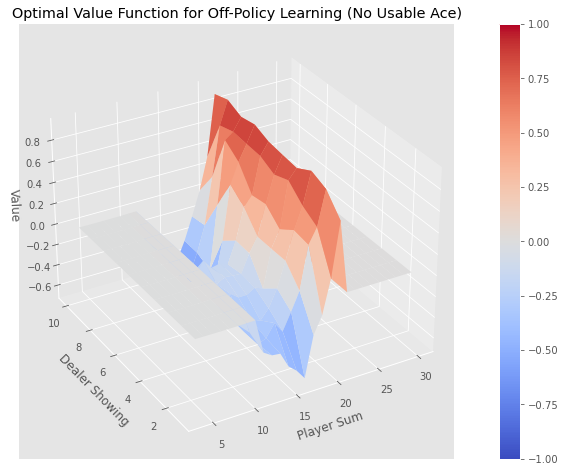

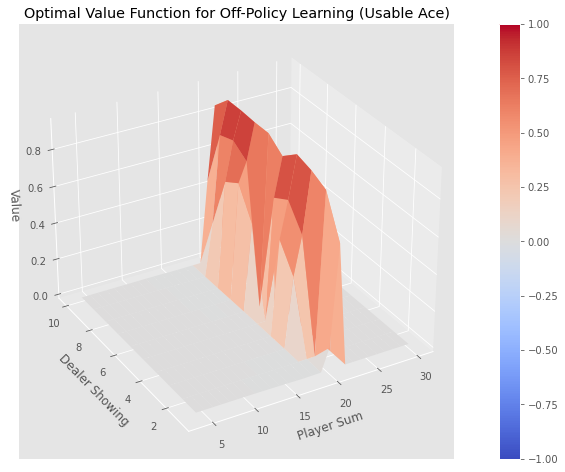

In [20]:
def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(16,8))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))

V = defaultdict(float)
for state, actions in Q.items():
    action_value = np.max(actions)
    V[state] = action_value
plot_value_function(V, title="Optimal Value Function for Off-Policy Learning")

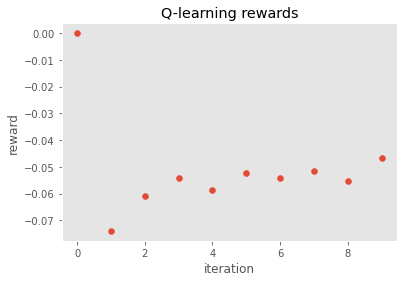

In [21]:
def show_rewards(rewards):
    avg_rewards = []
    sum_ = 0
    for i in range(len(rewards)):
        sum_ += rewards[i]
        if i % 100000 == 0:
            sum_ /= 100000
            avg_rewards.append(sum_)
            sum_ = 0
            
    iterations=np.arange(0, len(avg_rewards))
    fig, ax = plt.subplots(1, 1)
    ax.grid(None)
    ax.scatter(iterations, avg_rewards)
    ax.set_xlabel('iteration')
    ax.set_ylabel('reward')
    _ = ax.set_title('Q-learning rewards')

show_rewards(rewards)

Наилучшие параметры: 
- изначальное epsilon = 1.0, далее уменьшается вплоть до eps_min=0.05
- alpha = 0.01
- gamma = 0.01

# Часть третья, в главной роли — Дастин Хоффман #
А теперь давайте вспомним, как играют в блекджек настоящие профессионалы. Дело в том, что в оффлайн-казино обычно не перемешивают колоду после каждой раздачи — это слишком замедляло бы игру. После раздачи карты просто раздаются дальше с верха колоды до тех пор, пока карт не останется слишком мало, и только тогда колода перемешивается; давайте для определённости считать, что наше казино будет перемешивать колоду, в которой осталось меньше 15 карт.


Действительно, если вы будете запоминать, какие карты уже вышли, у вас будет информация о том, какие карты ещё остались, а это позволяет лучше понять, когда нужно удваивать ставку или делать split, а когда лучше не стоит. В настоящем казино могут раздавать карты сразу из нескольких колод, и заслуга Rain Man’а была в том, что он смог считать карты в шести колодах одновременно. Но мы с вами вооружены компьютерами, так что подсчёт можно считать автоматическим.

5. Реализуйте вариант окружения Blackjack-v0 из предыдущей части (с удвоением), в котором игрок имеет возможность “считать карты” в колоде. Это можно сделать разными способами; возможно, вам поможет статья википедии о блекджеке (а возможно, и нет).
6. Реализуйте метод обучения с подкреплением без модели для этого варианта, постройте графики, аналогичные п.2.

Была выбрана схема: 

| Карты          | Числовые значения |
|----------------|-------------------|
| 2, 3, 4, 5, 6  | +1                |
| 7, 8, 9        | 0                 |
| 10, В, Д, К, Т | -1                |

Текущий "счет" колоды был добавлен как еще одно состояние.

In [32]:
import Blackjack_double_counting

In [33]:
env = Blackjack_double_counting.BlackjackEnv()
_ = env.reset()
rewards = []
Q = off_pol_TD_Q_learn(env, 1000000, 1, 0.05, 0.02)

Episode 1000000/1000000.

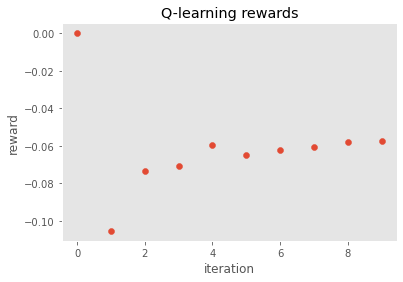

In [34]:
show_rewards(rewards)

Наилучшие параметры: 
- изначальное epsilon = 1.0, далее уменьшается вплоть до eps_min=0.05
- alpha = 0.05
- gamma = 0.02